In [1]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel

# import adapters
# from adapters import AutoAdapterModel
# import gc

import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
torch.__version__
# transformers.__version__

'2.1.1+cu121'

In [3]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop
from text_embeddings_src.data_stuff import (
    SameSentencePairDataset,
)
from text_embeddings_src.embeddings import generate_embeddings
from text_embeddings_src.metrics import knn_accuracy

# from text_embeddings_src.dim_red import run_tsne_simple
# from text_embeddings_src.plotting import plot_tsne_colors

In [4]:
# # test
# import simcse

In [5]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [6]:
variables_path = Path("../../results/variables")
# variables_pubmed_path = Path("../../pubmed-landscape/results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [7]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [8]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [9]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-08-07 15:58:09CEST

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

transformers: 4.35.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

pandas             : 2.1.3
matplotlib         : 3.8.2
numpy              : 1.26.2
jupyter_black      : 0.3.4
text_embeddings_src: 0.0.0
torch              : 2.1.1
memory_profiler    : 0.61.0
black              : 23.11.0
distro             : 1.8.0

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import ICLR dataset

In [10]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 298 ms, sys: 99.7 ms, total: 398 ms
Wall time: 478 ms


In [11]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [12]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [13]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [14]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

# Functions

In [15]:
def fix_all_seeds(seed=42):
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  ## this one is new
    ## Set the seed for generating random numbers on all GPUs.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True) ## this one I don't use but don't remember why

    # Set the random seed for NumPy
    np.random.seed(seed)

    # Set the random seed
    random.seed(seed)

# Run their code

## Create csv for SimCSE training
Get the datasets: you can either provide your own CSV/JSON/TXT training and evaluation files (see below)
or just provide the name of one of the public datasets available on the hub at https://huggingface.co/datasets/
(the dataset will be downloaded automatically from the datasets Hub

For CSV/JSON files, this script will use the column called 'text' or the first column. You can easily tweak this
behavior (see below)

## Try to run their code

In [ ]:
df = pd.DataFrame()
df.head()

""


In [ ]:
df["text"] = iclr2024.abstract

In [ ]:
df.head()

,text
0,We introduce a design strategy for neural netw...
1,We study the behavior of untrained neural netw...
2,We propose a LSTM parametrization that preser...
3,Recurrent neural nets are widely used for pred...
4,We propose a new formulation for pruning convo...


In [ ]:
df.to_csv(data_path / "iclr2024_train_simcse.csv")

In [ ]:
df = pd.read_csv(data_path / "iclr2024_train_simcse.csv")

In [ ]:
df

,Unnamed: 0,text
0,0,We introduce a design strategy for neural netw...
1,1,We study the behavior of untrained neural netw...
2,2,We propose a LSTM parametrization that preser...
3,3,Recurrent neural nets are widely used for pred...
4,4,We propose a new formulation for pruning convo...
...,...,...
24342,24342,Current evaluation protocols predominantly ass...
24343,24343,In the battle against widespread online misinf...
24344,24344,"Recently, Vision Transformer has achieved grea..."
24345,24345,Mixed integer linear programs (MILP) are flex...


In [ ]:
type(df.text.iloc[0])

str

In [ ]:
df.text.to_list()

['We introduce a design strategy for neural network macro-architecture based on self-similarity.  Repeated application of a simple expansion rule generates deep networks whose structural layouts are precisely truncated fractals.  These networks contain interacting subpaths of different lengths, but do not include any pass-through or residual connections; every internal signal is transformed by a filter and nonlinearity before being seen by subsequent layers.  In experiments, fractal networks match the excellent performance of standard residual networks on both CIFAR and ImageNet classification tasks, thereby demonstrating that residual representations may not be fundamental to the success of extremely deep convolutional neural networks.  Rather, the key may be the ability to transition, during training, from effectively shallow to deep.  We note similarities with student-teacher behavior and develop drop-path, a natural extension of dropout, to regularize co-adaptation of subpaths in f

In [ ]:
# save as txt
with open(data_path / "iclr2024_train_simcse.txt", "w") as fp:
    fp.write("\n".join(df.text.to_list()))

In [15]:
%%time

import subprocess

python_file_path = (
    nb_path / "train-simcse.py"
)  ## same as the train.py file of the SimCSE repo
data_file_path = data_path / "iclr2024_train_simcse.csv"
model_path = variables_path / "models/my-unsup-simcse-bert-base"

command = [
    "python",
    python_file_path,
    "--model_name_or_path",
    "bert-base-uncased",  # "microsoft/mpnet-base",
    # "--train_file",
    # data_file_path,
    "data_files",
    '{"train": "my_train_file.txt", "test": "my_test_file.txt"}',
    "--output_dir",
    model_path,
    "--num_train_epochs",
    "1",
    "--per_device_train_batch_size",
    "64",
    "--learning_rate",
    "2e-5",  ## originally 3e-5
    "--max_seq_length",
    "32",
    "--evaluation_strategy",
    # "no",  # added by me the no
    "steps",
    # "--metric_for_best_model", "stsb_spearman",
    "--load_best_model_at_end",
    # "--eval_steps", "125",
    "--pooler_type",
    "avg",  ## originally cls
    "--mlp_only_train",
    "--overwrite_output_dir",
    "--temp",
    "0.05",
    "--do_train",
    "--do_eval",
    "False",  ## originally True (default)
    "--fp16",
]

result = subprocess.run(command, capture_output=True, text=True)

print(result.stdout)
print(result.stderr)


2024-07-19 10:08:52.853904: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 10:08:52.884506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 10:08:52.884531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 10:08:52.885845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 10:08:52.892499: I tensorflow/core/platform/cpu_feature_gua

In [13]:
from datasets import load_dataset

# from datasets.Datasets import load_dataset

# Do it myself

## Tests

### Test dropout layers

In [10]:
dummy_corpus = [
    "The sun is shining brightly in the clear blue sky.",
    "The sun is shining brightly in the clear blue sky.",
    "She made a delicious chocolate cake for dessert.",
    "They are planning a trip to Paris next summer.",
    # "The soccer team won the championship game yesterday.",
    # "He bought a new smartphone with a high-resolution camera.",
]

In [11]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [22]:
%%time
# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model_untrained = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model_untrained.to(device)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 1.83 s, sys: 1.26 s, total: 3.1 s
Wall time: 1.5 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [23]:
model_untrained.train()
# preprocess the input
inputs = tokenizer(
    dummy_corpus,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)


out = model_untrained(**inputs)
token_embeds = out[0].detach().cpu().numpy()  # get the last hidden state

In [24]:
token_embeds.shape

(4, 13, 768)

In [25]:
token_embeds[0] == token_embeds[1]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### Test class
A class like the one we use but, instead of returning two different sentences from the same abstract, it returns the same one twice.

In [17]:
import itertools


# import re
class SameSentencePairDataset(torch.utils.data.Dataset):
    """
    Only the __getitem__ method changes with respect to the MultOverlappingSentencesPairDataset class.
    """

    def __init__(
        self,
        abstracts,
        tokenizer,
        device,
        n_cons_sntcs=2,
        tokenizer_kwargs=None,
        seed=42,
    ):
        self.abstracts = abstracts
        self.rng = np.random.default_rng(seed)
        self.n_cons_sntcs = n_cons_sntcs

        # sentence map
        self.sentences_map = []
        for i, sentences in enumerate(
            abstracts.map(lambda a: a.split("."))
        ):  # loop through abstracts
            for j in range(
                len(sentences) - (self.n_cons_sntcs - 1)
            ):  # loop through sentences inside abstract
                if (len(sentences[j]) >= 100) & (
                    len(sentences[j]) <= 250
                ):  # length conditions
                    cons_sentences_pack = ""
                    cons_sentence_counts = 0
                    for k in range(
                        len(sentences) - j
                    ):  # loop through sentences to add them
                        if (len(sentences[j + k]) >= 100) & (
                            len(sentences[j + k]) <= 250
                        ):  # length conditions
                            cons_sentences_pack += (
                                sentences[j + k].strip() + ". "
                            )
                            cons_sentence_counts += 1

                        if (
                            cons_sentence_counts == self.n_cons_sntcs
                        ):  # check if we have already enough sentences
                            self.sentences_map.append((cons_sentences_pack, i))
                            break

        if tokenizer_kwargs is None:
            tokenizer_kwargs = dict(
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt",
            )

        self.sentences_tok = tokenizer(
            [x for x, _ in self.sentences_map], **tokenizer_kwargs
        ).to(device)

        # we group the flat sentences by the original abstract they
        # come from.  Then we can check whether we have enough
        # sentences and append the abstracts with at least two
        # sentences to our list.
        sentences_and_toks = zip(
            self.sentences_map,
            self.sentences_tok["input_ids"],
            self.sentences_tok["attention_mask"],
        )
        self.abs_sentences = []
        self.abs_toks = []
        self.abs_amsk = []
        for key, group in itertools.groupby(
            sentences_and_toks,
            key=lambda kvtoksetc: kvtoksetc[0][1],
        ):
            grp = list(group)
            if len(grp) < 2:
                continue  # not enough sentences
            else:
                self.abs_sentences.append([kv[0] for kv in grp])
                self.abs_toks.append([x[1] for x in grp])
                self.abs_amsk.append([x[2] for x in grp])

        # we now have `self.abs_toks`, which is a list of lists,
        # where the first list is the abstracts and the second is the
        # token representation of the sentences within the given
        # abstract.

    def __getitem__(self, idx):
        abstract = self.abs_toks[idx]
        amask = self.abs_amsk[idx]
        i1 = self.rng.choice(
            len(abstract), size=None, replace=False
        )  # we randomly only one sentence from the abstract (size=None samples one element)
        return (abstract[i1], amask[i1]), (
            abstract[i1],
            amask[i1],
        )  # we return the same sentence and its mask twice

    def __len__(self):
        return len(self.abs_sentences)

In [80]:
# print(abstracts[0])
test_abstract = [
    "In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly.",
    "We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process.",
]
print(test_abstract)

['In cities with tall buildings, emergency responders need an accurate floor level location to find 911 callers quickly.', "We introduce a system to estimate a victim's floor level via their mobile device's sensor data in a two-step process."]


In [81]:
%%time
# data
training_dataset = SameSentencePairDataset(
    iclr2024.abstract[:2],
    tokenizer,
    device,
)

CPU times: user 57.1 ms, sys: 11.3 ms, total: 68.3 ms
Wall time: 6.33 ms


In [82]:
len(training_dataset)

2

In [83]:
test = training_dataset[0]
test

((tensor([    0,  5571,  4650,  2001,  1041,  3726,  4939,  3631, 19425,  2788,
           6129,  3009,  8336,  9625,  2019,  2028, 10789, 25453, 25316, 25576,
           4881,  1016,  2126,  6129,  5387, 21939,  4946, 15073,  2019,  2001,
           2371, 10746,  1014,  2025,  2083,  2029,  2425,  2155,  3417,  1015,
           2087,  2034, 21965,  7268,  1029,  2300,  4726,  4746,  2007,  8594,
           2015,  1041, 11311,  2002, 27404,  3016,  2081,  2112,  2468,  2015,
           4749,  9018,  1016,     2,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1], device='cuda:0'),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0], device='cuda:0')),
 (tensor([    0,  5571,  4650,  2001,  1041,  3726,  4939,  3631, 19425

In [84]:
print(test[0][0].detach().cpu().numpy())
print(test[1][0].detach().cpu().numpy())
test[0][0].detach().cpu().numpy() == test[1][0].detach().cpu().numpy()

[    0  5571  4650  2001  1041  3726  4939  3631 19425  2788  6129  3009
  8336  9625  2019  2028 10789 25453 25316 25576  4881  1016  2126  6129
  5387 21939  4946 15073  2019  2001  2371 10746  1014  2025  2083  2029
  2425  2155  3417  1015  2087  2034 21965  7268  1029  2300  4726  4746
  2007  8594  2015  1041 11311  2002 27404  3016  2081  2112  2468  2015
  4749  9018  1016     2     1     1     1     1     1     1     1     1
     1     1     1     1     1]
[    0  5571  4650  2001  1041  3726  4939  3631 19425  2788  6129  3009
  8336  9625  2019  2028 10789 25453 25316 25576  4881  1016  2126  6129
  5387 21939  4946 15073  2019  2001  2371 10746  1014  2025  2083  2029
  2425  2155  3417  1015  2087  2034 21965  7268  1029  2300  4726  4746
  2007  8594  2015  1041 11311  2002 27404  3016  2081  2112  2468  2015
  4749  9018  1016     2     1     1     1     1     1     1     1     1
     1     1     1     1     1]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

## Training for my data

Standard training with SimCSE augmentations

### Run 1

In [18]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [22]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies, model_trained_simcse = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
    return_model=True,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_simcse_1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_simcse_1",
    knn_accuracies,
)

print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 8min 22s, sys: 7min 37s, total: 15min 59s
Wall time: 8min 46s


In [24]:
print(knn_accuracies)

[array([0.46846154, 0.46769231, 0.46076923])]


In [ ]:
# old
# [array([0.46846154, 0.46769231, 0.46076923])]

[array([0.46846154, 0.46769231, 0.46076923])]


#### Save checkpoint

In [26]:
# Save the model and tokenizer
output_dir = Path("updated_dataset/model_checkpoints/mpnet_simcse_finetuning")
model_trained_simcse.save_pretrained(variables_path / output_dir)

#### Load test

In [10]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [13]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

# tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 1.64 s, sys: 1.6 s, total: 3.23 s
Wall time: 1.33 s


In [14]:
# # # load - test
checkpoint_dir = Path(
    "updated_dataset/model_checkpoints/mpnet_simcse_finetuning"
)  # or whatever path you saved to
model_trained_simcse = AutoModel.from_pretrained(
    variables_path / checkpoint_dir
)

In [15]:
model == model_trained_simcse

False

### Run 2
Same as run 1 but for 10 epochs

In [16]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [17]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_simcse_2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_simcse_2",
    knn_accuracies,
)

print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1h 12min 27s, sys: 1h 11min 5s, total: 2h 23min 32s
Wall time: 1h 26min 32s


/tmp/ipykernel_70964/3965496314.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)


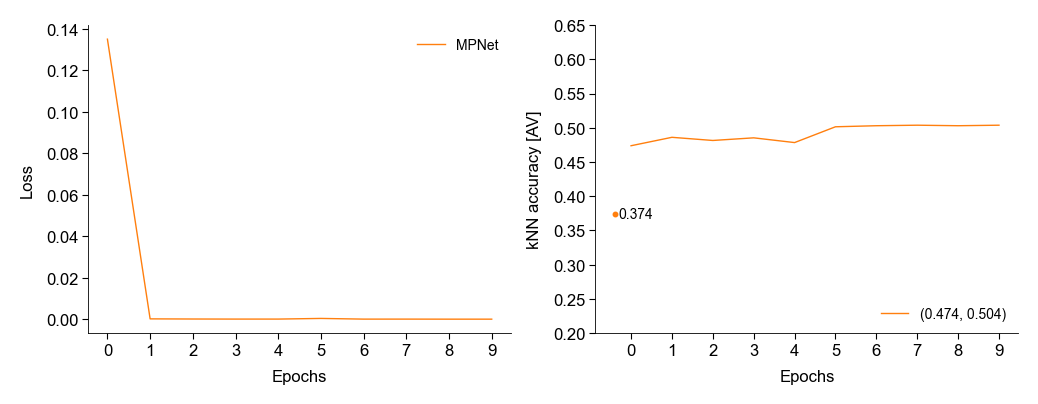

In [29]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    losses = np.load(variables_path / saving_path / "losses_run_simcse_2.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run_simcse_2.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    # plot
    color = colormap(1)

    axs[0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0].set_xticks(np.arange(n_epochs))
    # axs[0].set_ylim(top=0.05)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    axs[1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    axs[1].text(
        -0.3,
        knn_acc_highd[0],
        f"{knn_acc_highd[0]:.3f}",
        fontsize=5,
        va="center",
        ha="left",
    )
    axs[1].set_xticks(np.arange(n_epochs))
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("kNN accuracy [AV]")
    axs[1].legend(loc="lower right")

    # axs[1, 0].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 1],
    #     label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    #     color=color,
    # )
    # axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.2, 0.65)
    # axs[1, 0].set_xlabel("Epochs")
    # axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    # axs[1, 0].legend()

    # axs[1, 1].plot(
    #     np.arange(n_epochs),
    #     knn_accuracies[:, 2],
    #     label=model_name,
    #     color=color,
    # )
    # axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.2, 0.65)
    # axs[1, 1].set_xlabel("Epochs")
    # axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path / "loss_and_knn_accuracy_training_run_simcse_2_v2.png"
)

In [28]:
np.mean(losses, axis=1)

array([1.35042978e-01, 1.88162860e-04, 1.19715765e-04, 8.29865024e-05,
       8.59196578e-05, 4.01557755e-04, 6.87253919e-05, 7.28027159e-05,
       4.81837604e-05, 4.50655905e-05])

### Run 3 -- REPEAT

In [16]:
import torch
from tqdm.notebook import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool


def train_loop_without_eval(
    model,
    loader,
    device,
    optimized_rep="av",
    n_epochs=1,
    lr=2e-5,
):
    assert optimized_rep in [
        "av",
        "cls",
        "sep",
        "7th",
    ], "Not valid `optimized_rep`. Choose from ['av', 'cls', 'sep', '7th']."

    model.to(device)

    # define layers to be used in multiple-negatives-ranking
    cos_sim = torch.nn.CosineSimilarity()
    loss_func = torch.nn.CrossEntropyLoss()
    scale = 20.0  # we multiply similarity score by this scale value, it is the inverse of the temperature
    # move layers to device
    cos_sim.to(device)
    loss_func.to(device)

    # initialize Adam optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # setup warmup for first ~10% of steps
    total_steps = len(loader) * n_epochs
    warmup_steps = int(0.1 * len(loader))
    scheduler = get_linear_schedule_with_warmup(
        optim,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    losses = np.empty((n_epochs, len(loader)))
    accuracies = []
    for epoch in range(n_epochs):
        model.train()  # make sure model is in training mode
        # initialize the dataloader loop with tqdm (tqdm == progress bar)
        loop = tqdm(loader, leave=True)
        for i_batch, batch in enumerate(loop):
            # zero all gradients on each new step
            optim.zero_grad()
            # prepare batches and move all to the active device
            anchor_ids = batch[0][0].to(
                device
            )  # this are all anchor abstracts from the batch,len(anchor_ids)= len(batch)
            anchor_mask = batch[0][1].to(device)
            pos_ids = batch[1][0].to(
                device
            )  # this each positive pair from each anchor, all in one array, also len(batch)
            pos_mask = batch[1][1].to(device)
            # extract token embeddings from BERT
            a = model(anchor_ids, attention_mask=anchor_mask)[
                0
            ]  # all token embeddings
            p = model(pos_ids, attention_mask=pos_mask)[0]

            # get the mean pooled vectors  -- put all of these ifs into a pool function (wraper) to which I pass, a, p the masks and the optimized rep
            if optimized_rep == "av":
                a = mean_pool(a, anchor_mask)
                p = mean_pool(p, pos_mask)

            elif optimized_rep == "cls":
                a = cls_pool(a, anchor_mask)
                p = cls_pool(p, pos_mask)

            elif optimized_rep == "sep":
                a = sep_pool(a, anchor_mask)
                p = sep_pool(p, pos_mask)

            elif optimized_rep == "7th":
                a = seventh_pool(a, anchor_mask)
                p = seventh_pool(p, pos_mask)

            # calculate the cosine similarities
            scores = torch.stack(
                [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
            )
            # get label(s) - we could define this before if confident
            # of consistent batch sizes
            labels = torch.tensor(
                range(len(scores)), dtype=torch.long, device=scores.device
            )  # I think that the labels are just the label of which pair it is. 0 for the first pair, 1 for the second...
            # my guess is that they are used in the loss to know which of the cosine similarities should be high
            # and which low

            # and now calculate the loss
            loss = loss_func(scores * scale, labels)
            losses[epoch, i_batch] = loss.item()

            # using loss, calculate gradients and then optimize
            loss.backward()
            optim.step()
            # update learning rate scheduler
            scheduler.step()
            # update the TDQM progress bar
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

    return model, losses

In [17]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [18]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
model_trained, losses = train_loop_without_eval(
    model,
    training_loader,
    device,
    optimized_rep="av",
    n_epochs=20,
    lr=2e-5,
)

# evaluation
## get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings(iclr2024.abstract.to_list(), tokenizer, model_trained, device, batch_size=256)

## run knn
knn_accuracies = knn_accuracy(
                    [
                        embedding_av[labels_iclr != "unlabeled"],
                        embedding_cls[labels_iclr != "unlabeled"],
                        embedding_sep[labels_iclr != "unlabeled"],
                    ],
                    labels_iclr[labels_iclr != "unlabeled"],
                )

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_simcse_3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_simcse_3",
    knn_accuracies,
)

print("----------------------------")

Model:  MPNet
Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

In [19]:
print(knn_accuracies)

[0.50384615 0.49384615 0.48615385]


In [21]:
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
# (variables_path / saving_path).mkdir(exist_ok=True)

np.load(variables_path / saving_path / "knn_accuracies_run_simcse_3.npy")

array([0.50384615, 0.49384615, 0.48615385])